In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = '330k-arabic-sentiment-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5577640%2F9222859%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240911%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240911T124321Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbbd89fb3556eedfca054a1d97b8302a16f4da6623f1c75c643996c73997fbc3b29921ab5ceb889655d65ae843b0455e19271751bdc03f170bebb0a066ed172fdfe37a91ae2447343fee507f043e4411c57a1b59e5003952e440d2617d49a5cd76589ffaae3b03bbb05a58b0e371481eb49718269f43437a7e8efb2a64ddba7565a765f40298aa9b231df2ed6acc368bad6f2315328bbe0ee8a7bffa067f0f14b510f9d346cd36824cbfab9d9ee055521389719507ef99897de4bc744247947248edc065499218fb765c37a3161a4608bfc8ae2e1bfaf0e9adc9923a9da16ae4185734dd5a9a4fc2887a50014034a89774655d0ca24d33308a9a1466d89b7ae63'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 67426264 bytes downloaded
Downloaded and uncompressed: 330k-arabic-sentiment-reviews
Data source import complete.


# installing and importing libraries

In [ ]:
!pip install wordcloud
!pip install pyarabic
!pip install arabic-reshaper
!pip install python-bidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 6.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display

import os
import re ,string
from collections import Counter

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pyarabic.araby as ar
from nltk.stem.isri import ISRIStemmer


from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Embedding, Dense, Input, Dropout, Bidirectional

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/330k-arabic-sentiment-reviews/arabic_sentiment_reviews.csv


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# preprocess data + EDA

In [ ]:
data=pd.read_csv('/kaggle/input/330k-arabic-sentiment-reviews/arabic_sentiment_reviews.csv')

In [ ]:
data.head()

,label,content
0,1,النعال المريحة: أرتدي هذه النعال كثيرًا!فهي دا...
1,1,منتج جميل ، خدمة سيئة: لقد اشتريت زوجًا من الن...
2,1,جيد للأشياء الصغيرة: هذا يعمل بشكل جيد لالتقاط...
3,0,واهية للغاية: flimsyif للغاية ، فأنت تشتريه ، ...
4,1,Pop for Girls and Girly Boys ، والأشخاص الذين ...


In [ ]:
data.tail()

,label,content
329995,0,DOA: فتح العلامة التجارية الجديدة من Box.تم تث...
329996,0,شركة صعبة التعامل معها: المنتج كان على ما يرام...
329997,0,SDK Sansa Leather Case: فقير للغاية.لم يتم الإ...
329998,0,حسنًا ، لكن ليس رائعًا: حسنًا ، لقد اشتريت هذا...
329999,1,مريحة جدا!: هذه النعال رائعة!أنها ناعمة جدا وم...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330000 entries, 0 to 329999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   label    330000 non-null  int64 
 1   content  330000 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.0+ MB


In [ ]:
print("num of None data:")
print(data.isna().sum())

print("-"*50)
print("num of Null data:")
print(data.isnull().sum())

print("-"*50)
print("num of duplicated data:")
print(data.duplicated().sum())

num of None data:
label      0
content    0
dtype: int64
--------------------------------------------------
num of Null data:
label      0
content    0
dtype: int64
--------------------------------------------------
num of duplicated data:
32


In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
num_positive=len(data[data["label"]==1])
num_negative=len(data[data["label"]==0])

print("number of positive sentece: ",num_positive)
print("number of negative sentece: ",num_negative)

total=num_positive+num_negative
difference=num_positive-num_negative
print("difference=",difference)
print(f"difference percantge= {int(difference/total*100)}%")

number of positive sentece:  166844
number of negative sentece:  163124
difference= 3720
difference percantge= 1%


<ipython-input-22-6fa57e773f40>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='label', palette=[colors[3], colors[8]])


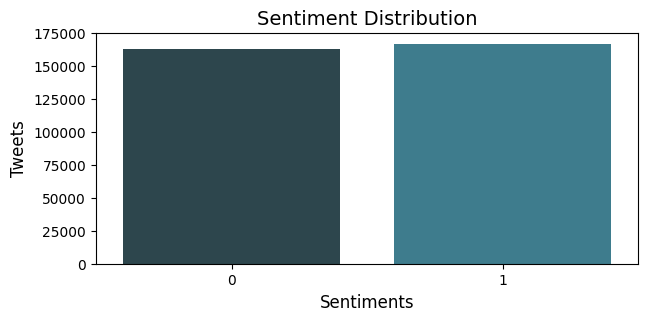

In [ ]:
plt.figure(figsize=(7,3))
colors = sns.dark_palette("#328fa8", n_colors=10, input='rgb')
sns.countplot(data=data, x='label', palette=[colors[3], colors[8]])
plt.xlabel("Sentiments", size=12)
plt.ylabel('Tweets', size=12)
plt.title("Sentiment Distribution", size=14)
plt.show()

In [ ]:
def common_word(data):
  data = data.apply(lambda x:str(x).split())
  top = Counter([item for sublist in data for item in sublist])
  temp = pd.DataFrame(top.most_common(20))
  temp.columns = ['Common_words','count']
  return temp


In [ ]:
  temp=common_word(data['content'])


In [ ]:
temp.head()

,Common_words,count
0,،,990489
1,من,635839
2,في,507792
3,على,360409
4,هذا,355559


In [ ]:
  fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
  fig.show()

In [ ]:
x=data["content"]
y=data["label"]

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=.8)

In [ ]:
# Initialize necessary variables

stop_words = set(stopwords.words('arabic'))
punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation
st = ISRIStemmer()

In [ ]:
def remove_urls(text):
    return re.sub(r"http\S+", "", text)

In [ ]:
def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

In [ ]:
def remove_numbers(text):
    return re.sub("\d+", " ", text)

In [ ]:
def remove_special_characters(text):
    text = text.replace("#", " ")
    text = text.replace("@", " ")
    text = text.replace("_", " ")
    return text

In [ ]:
def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations)
    return text.translate(translator)

In [ ]:
def remove_english(text):
    return re.sub('[A-Za-z0-9]', ' ', text)

In [ ]:
def stem_text(text):
    return " ".join([st.stem(i) for i in text.split()])

In [ ]:
def normalize_arabic(text):
    arabic_normalization_map = {
        "إ": "ا", "أ": "ا", "آ": "ا", "ى": "ي", "ؤ": "ء", "ئ": "ء", "ة": "ه", "گ": "ك"
    }
    return text.translate(str.maketrans(arabic_normalization_map))

In [ ]:
def remove_stop_words(text):
    return ' '.join(word for word in text.split() if word not in stop_words)

In [ ]:
def clean_text(text, normalize=True, stem=True):

    if not isinstance(text, str):
        return ""

    text = remove_urls(text)
    text = remove_extra_spaces(text)
    text = remove_numbers(text)
    text = ar.strip_tashkeel(text)
    text = ar.strip_tatweel(text)
    text = remove_special_characters(text)
    text = remove_punctuations(text)
    text = remove_english(text)
    text = remove_stop_words(text)

    if normalize:
        text = normalize_arabic(text)
    if stem:
        text = stem_text(text)

    return text


In [ ]:
clean_test=pd.DataFrame(x_train.head())
clean_test['cleaned'] = clean_test['content'].apply(lambda x: clean_text(x, normalize=False, stem=False))

In [ ]:
print(clean_test['content'].iloc[2])
print("-"*50)
print(clean_test["cleaned"].iloc[2])

منتج جيد ، ولكن الوصف المضللة: المنتج يعمل بشكل جيد ، ومع ذلك ، فإن مجموعة الضوء لا تستخدم المصابيح الأساسية E27.يستخدم مصابيح الشمعدانات الأصغر ولا تأتي مع أي CFLs.لم أكن قد دفعت بقدر ما عرفت أن المنتج لم يكن كما هو موضح.
--------------------------------------------------
منتج جيد الوصف المضللة المنتج يعمل بشكل جيد ومع مجموعة الضوء تستخدم المصابيح الأساسية يستخدم مصابيح الشمعدانات الأصغر تأتي أكن دفعت بقدر عرفت المنتج يكن موضح


In [ ]:
clean_train_vi=data['content'].apply(lambda x: clean_text(x, normalize=False, stem=True))
common_train=common_word(clean_train_vi)

In [ ]:
common_train.head(20)

,Common_words,count
0,كتب,249119
1,جيد,107318
2,رئع,106661
3,انه,99272
4,يلم,96149
5,شكل,95730
6,فضل,90057
7,عمل,86474
8,شيء,85350
9,شخص,82500


In [ ]:
  fig = px.bar(common_train, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
  fig.show()

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
def word2cloud(word_freq):

    # Reshape Arabic text to make it display correctly in word cloud
    reshaped_words = {arabic_reshaper.reshape(k): v for k, v in word_freq.items()}

    # Generate the word cloud with reshaped Arabic text
    wordcloud = WordCloud(
        font_path=None,  # You can specify a custom Arabic font if needed
        width=800,
        height=400,
        background_color='white',
        max_words=200,
        colormap='viridis'
    ).generate_from_frequencies(reshaped_words)

    plt.figure(figsize=(10, 5))

    # Correctly display Arabic text (from reshaped to bidi)
    plt.imshow(get_display(wordcloud), interpolation='bilinear')

    plt.axis('off')  # Remove axes
    plt.show()


In [ ]:
x_train_model=x_train.apply(clean_text)
x_test_model=x_test.apply(clean_text)

In [ ]:
x_train_model.head()

,content
206890,فضل ريه طلق يجب عرف كنت وحد كثر كان تشك كتب كي...
276433,رجع متز رجع لغه رتر عام متز برمج ذوي خبرهليس ر...
291233,نتج جيد وصف ضلل نتج عمل شكل جيد ومع جمع ضوء خد...
248220,فزز فكر غيه يلم ثير تفكيركنت ربك حد طول يلم قل...
4575,بخب امل عرض علق حتو كتب فقط جودهيال خيب للقد ش...


# model training

In [ ]:
padding_type='post'
oov_tok = "<OOV>"
max_length = max(len(data) for data in x_train_model)
print(max_length)
vocab_size=25000

586


In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Fit the tokenizer on the training data
tokenizer.fit_on_texts(x_train_model)

# Convert the training and testing data to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train_model)
x_test_seq = tokenizer.texts_to_sequences(x_test_model)

x_train_padded = pad_sequences(x_train_seq, maxlen=max_length, padding='post')
x_test_padded = pad_sequences(x_test_seq, maxlen=max_length, padding='post')


In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Bidirectional(GRU(units = 32)))
model.add(Dense(32, activation = 'tanh'))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train_padded, y_train, epochs = 10,  validation_data=(x_test_padded, y_test),  batch_size= 128, shuffle = True)

Epoch 1/10
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 92s 41ms/step - accuracy: 0.8030 - loss: 0.4199 - val_accuracy: 0.8553 - val_loss: 0.3349
Epoch 2/10
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 136s 41ms/step - accuracy: 0.8733 - loss: 0.3017 - val_accuracy: 0.8657 - val_loss: 0.3124
Epoch 3/10
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 141s 40ms/step - accuracy: 0.8898 - loss: 0.2689 - val_accuracy: 0.8676 - val_loss: 0.3114
Epoch 4/10
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 143s 41ms/step - accuracy: 0.9037 - loss: 0.2393 - val_accuracy: 0.8685 - val_loss: 0.3132
Epoch 5/10
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 141s 41ms/step - accuracy: 0.9163 - loss: 0.2122 - val_accuracy: 0.8632 - val_loss: 0.3333
Epoch 6/10
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 148s 44ms/step - accuracy: 0.9292 - loss: 0.1855 - val_accuracy: 0.8602 - val_loss: 0.3461
Epoch 7/10
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 87s 42ms/step - accuracy: 0.9404 - loss: 0.1586 - val_accuracy: 0.8578 - val_loss: 0.3801
Epoch 8/10
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 148s 45ms/step - accuracy: 0.

In [ ]:
model.save('model.h5')

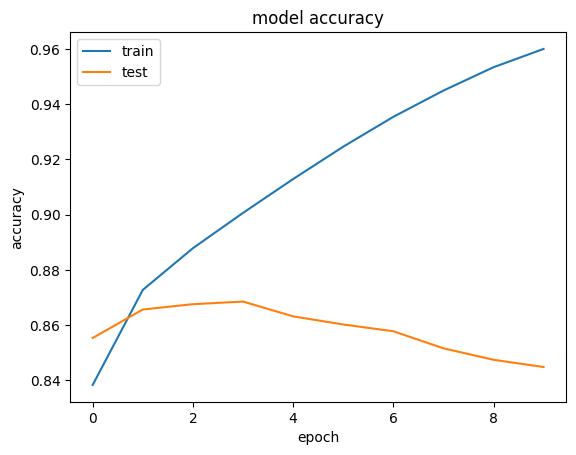

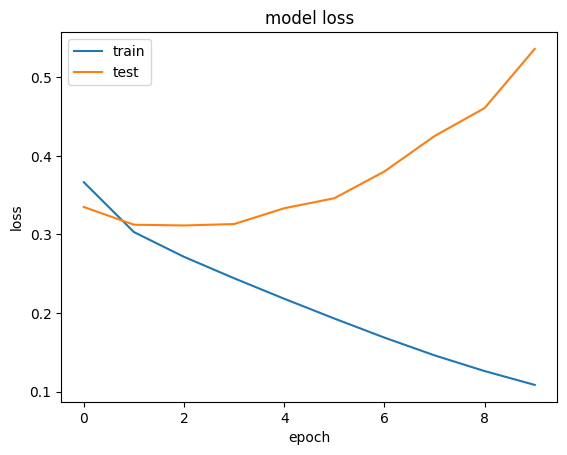

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
x_train_model = tfidf_vectorizer.fit_transform(x_train_model)



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB()
}

# Dictionary to store model performance
model_performance = {}

for model_name, model in models.items():
    model.fit(x_train_model, y_train)

    y_train_pred = model.predict(x_train_model)

    training_accuracy = accuracy_score(y_train, y_train_pred)
    precision = precision_score(y_train, y_train_pred, average='weighted')
    recall = recall_score(y_train, y_train_pred, average='weighted')
    f1 = f1_score(y_train, y_train_pred, average='weighted')

    # Store performance metrics in the dictionary
    model_performance[model_name] = {
        "Training Accuracy": training_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

    print(f"Model: {model_name}")
    print(f"Training Accuracy: {training_accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("--" * 20)


Model: Logistic Regression
Training Accuracy: 0.871185606060606
Precision: 0.8712137643583673
Recall: 0.871185606060606
F1 Score: 0.8711745068134038
----------------------------------------
Model: Naive Bayes
Training Accuracy: 0.887905303030303
Precision: 0.8880404489932241
Recall: 0.887905303030303
F1 Score: 0.8879072846183609
----------------------------------------


In [ ]:
# Convert model performance dictionary to DataFrame
df_performance = pd.DataFrame(model_performance).T
df_performance.reset_index(inplace=True)
df_performance.rename(columns={'index': 'Model'}, inplace=True)
df_performance.style.background_gradient(cmap='Purples')

,Model,Training Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.871186,0.871214,0.871186,0.871175
1,Naive Bayes,0.887905,0.888040,0.887905,0.887907
